# 02_comparacion_resultados — Baselines A/D

**Objetivo:** consolidar y analizar resultados de los tres baselines (reglas, TF‑IDF, transformer). 
**Exportables:** `data/02_baselines_comparacion.csv` con métricas clave (macro F1/Prec/Rec, n).


In [14]:
# ===============================================================
# Setup: Imports y configuración de paths
# ===============================================================
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo de visualizaciones
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

# Importar utilidades compartidas
try:
    from utils_shared import setup_paths
    paths = setup_paths()
    DATA_PATH = paths['DATA_PATH']
    FIGS_PATH = paths['FIGS_PATH']
    print("[OK] Usando utils_shared.py")
except ImportError:
    print("[WARNING] No se encontró utils_shared.py, usando configuración manual")
    BASE_PATH = Path.cwd()
    if BASE_PATH.name == "notebooks":
        BASE_PATH = BASE_PATH.parent
    DATA_PATH = BASE_PATH / "data"
    FIGS_PATH = DATA_PATH / "figs"
    FIGS_PATH.mkdir(exist_ok=True)

print(f" DATA_PATH: {DATA_PATH}")
print(f" FIGS_PATH: {FIGS_PATH}")


[OK] Usando utils_shared.py
 DATA_PATH: /Users/manuelnunez/Projects/psych-phenotyping-paraguay/data
 FIGS_PATH: /Users/manuelnunez/Projects/psych-phenotyping-paraguay/data/figs


## 1) Cargar métricas y unificar

In [15]:
import pandas as pd
from pathlib import Path

DATA_PATH = Path(DATA_PATH) if 'DATA_PATH' in globals() else Path('data')

paths = {
    "rule_based": {
        "eval": DATA_PATH/'rule_based_eval.csv',
        "report": DATA_PATH/'rule_based_classification_report.csv',
        "pred": DATA_PATH/'rule_based_predictions.csv',
    },
    "tfidf": {
        "eval": DATA_PATH/'tfidf_eval.csv',
        "report": DATA_PATH/'tfidf_classification_report.csv',
        "pred": DATA_PATH/'tfidf_predictions.csv',
    },
    "beto": {
        "eval": DATA_PATH/'beto_eval.csv',
        "report": DATA_PATH/'beto_classification_report.csv',
        "pred": DATA_PATH/'beto_predictions.csv',
    }
}

def pick(series, *names, default=None):
    """Devuelve el primer nombre presente en la serie."""
    for n in names:
        if n in series:
            return series[n]
    return default

rows = []
for name, ps in paths.items():
    if ps["eval"].exists():
        ev = pd.read_csv(ps["eval"]).iloc[0].to_dict()
        # Aceptar con o sin prefijo 'eval_'
        macro_f1       = pick(ev, "macro_f1", "eval_macro_f1")
        macro_prec     = pick(ev, "macro_precision", "eval_macro_precision")
        macro_rec      = pick(ev, "macro_recall", "eval_macro_recall")
        n_val          = pick(ev, "n")  # puede no existir en beto_eval
        if pd.isna(n_val) or n_val is None:
            # fallback: contar filas de predicciones si existe
            if ps.get("pred") and Path(ps["pred"]).exists():
                n_val = len(pd.read_csv(ps["pred"]))
        rows.append({"baseline": name,
                     "macro_f1": macro_f1,
                     "macro_precision": macro_prec,
                     "macro_recall": macro_rec,
                     "n": n_val})
    else:
        rows.append({"baseline": name, "macro_f1": None, "macro_precision": None, "macro_recall": None, "n": None})

comp = pd.DataFrame(rows, columns=["baseline","macro_f1","macro_precision","macro_recall","n"])
out_csv = DATA_PATH/'02_baselines_comparacion.csv'
comp.to_csv(out_csv, index=False, encoding='utf-8')
comp


,baseline,macro_f1,macro_precision,macro_recall,n
0,rule_based,0.496333,0.503370,0.502395,646.0
1,tfidf,0.755270,0.745770,0.768432,646.0
2,beto,0.741577,0.736377,0.747711,646.0


## 2) Visualización comparativa de métricas

[OK] Gráfica guardada: /Users/manuelnunez/Projects/psych-phenotyping-paraguay/data/figs/02_comparacion_metricas.png


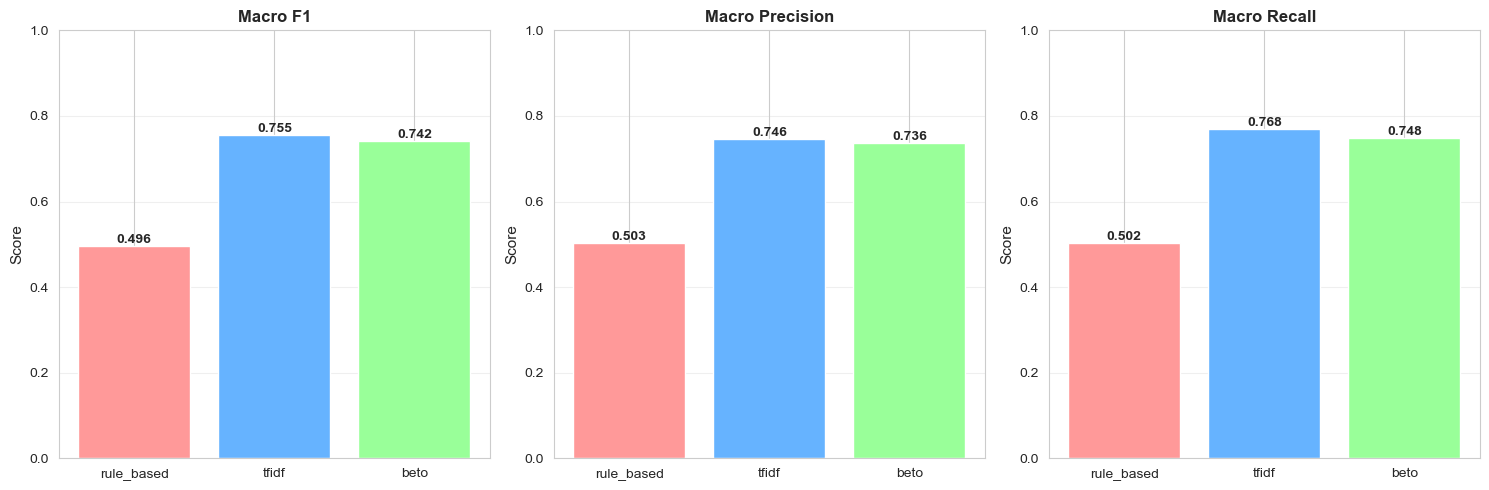


 Tabla resumen de resultados:


,baseline,macro_f1,macro_precision,macro_recall,n
0,rule_based,0.4963,0.5034,0.5024,646
1,tfidf,0.7553,0.7458,0.7684,646
2,beto,0.7416,0.7364,0.7477,646


In [16]:
# ===============================================================
# Gráfica de barras comparativa de métricas principales
# ===============================================================

# Filtrar solo baselines con métricas (no None)
comp_clean = comp[comp['macro_f1'].notna()].copy()

if len(comp_clean) == 0:
    print("[WARNING] No hay métricas disponibles para visualizar.")
    print(" Ejecuta los 3 baselines primero.")
else:
    # Preparar datos para plotting
    metrics_to_plot = ['macro_f1', 'macro_precision', 'macro_recall']

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx]

        # Crear barplot
        bars = ax.bar(comp_clean['baseline'], comp_clean[metric], 
        color=['#ff9999', '#66b3ff', '#99ff99'][:len(comp_clean)])

        # Añadir valores encima de las barras
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

        # Configurar ejes
        ax.set_ylim(0, 1.0)
        ax.set_ylabel('Score', fontsize=11)
        ax.set_title(metric.replace('_', ' ').title(), fontsize=12, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig(FIGS_PATH / '02_comparacion_metricas.png', dpi=150, bbox_inches='tight')
    print(f"[OK] Gráfica guardada: {FIGS_PATH / '02_comparacion_metricas.png'}")
    plt.show()

    # Mostrar tabla resumen
    print("\n Tabla resumen de resultados:")
    print("="*80)
    display(comp_clean.style.format({
        'macro_f1': '{:.4f}',
        'macro_precision': '{:.4f}',
        'macro_recall': '{:.4f}',
        'n': '{:.0f}'
    }).background_gradient(subset=['macro_f1', 'macro_precision', 'macro_recall'], 
                        cmap='RdYlGn', vmin=0, vmax=1))

## 3) Análisis por clase (Depresión vs Ansiedad)

[OK] Gráfica guardada: /Users/manuelnunez/Projects/psych-phenotyping-paraguay/data/figs/02_comparacion_por_clase.png


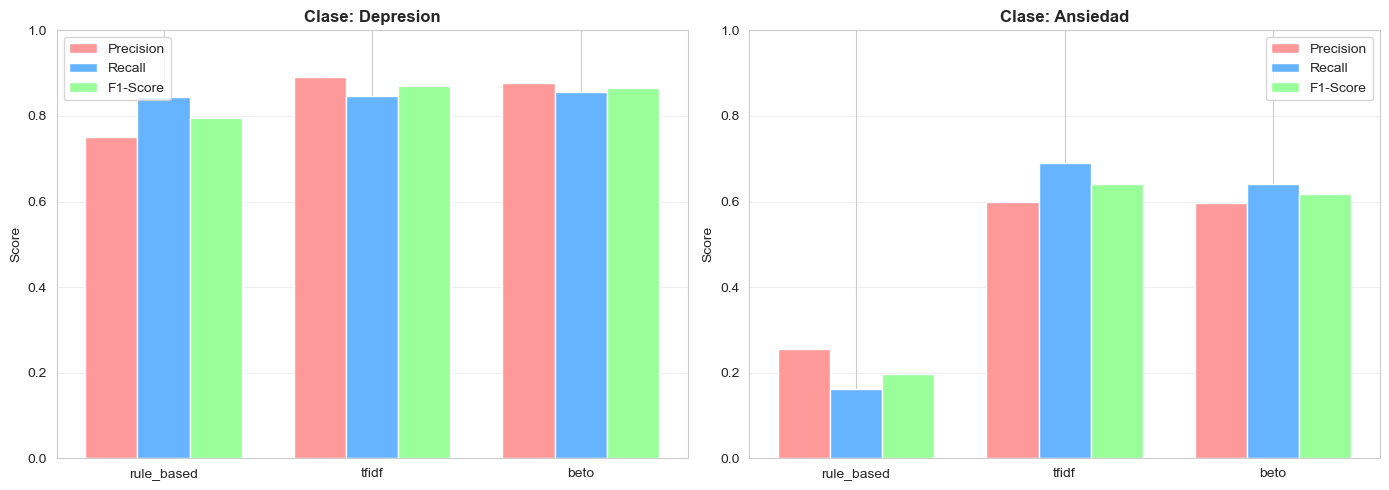


 Resultados detallados por clase:


clase,ansiedad,depresion
baseline,,
beto,0.6168,0.8664
rule_based,0.1977,0.7949
tfidf,0.6416,0.8689


In [17]:
# ===============================================================
# Comparar desempeño por clase usando classification reports
# ===============================================================

per_class_results = []

for name, ps in paths.items():
    if ps["report"].exists():
        report_df = pd.read_csv(ps["report"], index_col=0)
        
        # Extraer métricas por clase (depresion y ansiedad)
        for clase in ['depresion', 'ansiedad']:
            if clase in report_df.index:
                per_class_results.append({
                    'baseline': name,
                    'clase': clase,
                    'precision': report_df.loc[clase, 'precision'],
                    'recall': report_df.loc[clase, 'recall'],
                    'f1-score': report_df.loc[clase, 'f1-score']
                })

if per_class_results:
    df_per_class = pd.DataFrame(per_class_results)
    
    # Visualización por clase
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    for idx, clase in enumerate(['depresion', 'ansiedad']):
        ax = axes[idx]
        data_clase = df_per_class[df_per_class['clase'] == clase]
        
        if len(data_clase) > 0:
            x = np.arange(len(data_clase))
            width = 0.25
            
            # Barras para cada métrica
            ax.bar(x - width, data_clase['precision'], width, label='Precision', color='#ff9999')
            ax.bar(x, data_clase['recall'], width, label='Recall', color='#66b3ff')
            ax.bar(x + width, data_clase['f1-score'], width, label='F1-Score', color='#99ff99')
            
            ax.set_ylabel('Score')
            ax.set_title(f'Clase: {clase.capitalize()}', fontsize=12, fontweight='bold')
            ax.set_xticks(x)
            ax.set_xticklabels(data_clase['baseline'])
            ax.legend()
            ax.set_ylim(0, 1.0)
            ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGS_PATH / '02_comparacion_por_clase.png', dpi=150, bbox_inches='tight')
    print(f"[OK] Gráfica guardada: {FIGS_PATH / '02_comparacion_por_clase.png'}")
    plt.show()
    
    # Tabla de resultados por clase
    print("\n Resultados detallados por clase:")
    print("="*80)
    pivot_f1 = df_per_class.pivot(index='baseline', columns='clase', values='f1-score')
    display(pivot_f1.style.format('{:.4f}').background_gradient(cmap='RdYlGn', vmin=0, vmax=1))
else:
    print("[WARNING] No hay reportes de clasificación disponibles.")

## 4) Interpretación de resultados y recomendaciones

## 4) Análisis Completo

Para análisis detallado de resultados, errores, y próximos pasos, ver:

**📄 `RESULTADOS_BASELINES_README.md`**

Este documento incluye:
- ✅ Resultados por clase (Depresión vs Ansiedad)
- ✅ Matrices de confusión interpretadas
- ✅ Análisis de errores sistemáticos (5 categorías principales)
- ✅ Comparación con/sin data leakage
- ✅ Fortalezas/debilidades de cada modelo
- ✅ Validación de calidad (dummy baselines, casos conflictivos)
- ✅ Implicaciones para tesis y defensa

**📄 `PLAN_3_SEMANAS.md`**

Plan detallado para cierre de baselines y presentación:
- Semana 1: Validación y análisis de casos difíciles
- Semana 2: Experimentos de mejora (ensemble, vocabulario PY)
- Semana 3: Consolidación y presentación

---

### Resumen Ejecutivo

| Modelo | F1 Macro | F1 Depresión | F1 Ansiedad |
|--------|----------|--------------|-------------|
| **TF-IDF char(3,5)** | **0.755** | 0.869 | 0.642 |
| **BETO fine-tuned** | **0.742** | 0.866 | 0.617 |
| **Rule-based (COL)** | **0.496** | 0.795 | 0.198 |

**Conclusión:** TF-IDF y BETO tienen performance equivalente (diferencia de 1.3%, no significativa). El problema A/D es fundamentalmente léxico-discriminativo.